In [1]:
import time
import pandas as pd
import psycopg2
import datetime
from tqdm import trange
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import seaborn as sns
import math
# %matplotlib inline 
import platform
import numpy as np
from matplotlib import font_manager, rc # plt.rcParams['axes.unicode_minus'] = False 
if platform.system() == 'Darwin': rc('font', family='AppleGothic') 
elif platform.system() == 'Windows': 
    path = "c:/Windows/Fonts/malgun.ttf" 
    font_name = font_manager.FontProperties(fname=path).get_name() 
    rc('font', family=font_name) 
else: 
    print('Unknown system... sorry~~~~')
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
from tqdm import tqdm
from tqdm import trange

In [2]:
# 시계열
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [3]:
    # row 생략 없이 출력
pd.set_option('display.max_rows', 1000)
# col 생략 없이 출력
pd.set_option('display.max_columns', 1000)
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2

In [4]:
# DB 연결 부분
uswer = 'dt.intern'
host = '10.80.0.234'
port = '5439'
dbname = 'fnf'
con = psycopg2.connect(dbname='fnf',host='10.80.0.234', port='5439', user = 'dt.intern', password='DTintn0926')
cur = con.cursor()

In [5]:
# 전체 매장 입출판재
total_shop_stock = pd.read_csv("total_shop_stock.csv")
total_shop_stock = total_shop_stock.iloc[ :,1:]

# 매장정보
shop_info_pd = pd.read_csv("shop_info_pd.csv")
shop_info_pd = shop_info_pd.iloc[ :,1:]

# bucket_dwalker 관련 매장입출판재(2019)
bucket_dwalker = pd.read_csv('bucket_dwalker.csv')
bucket_dwalker = bucket_dwalker.iloc[ :,1:]

# bucket_dwalker_v2 관련 매장입출판재
bucket_dwalker_v2 = pd.read_csv('bucket_dwalker_v2.csv')
bucket_dwalker_v2 = bucket_dwalker_v2.iloc[ :,1:]

# 아울렛 상설을 제외한 매장키 
shop_list_pd = pd.read_csv('shop_list.csv')
shop_list_pd = shop_list_pd.iloc[ :,1:]

# 전체 매장 비어있는 주차 채운 데이터 (버킷 디워커 기준)
shop_weeks_buket_df = pd.read_csv('shop_weeks_buket.csv')
shop_weeks_buket_df = shop_weeks_buket_df.iloc[ :,1:]

# 전체 매장 비어있는 주차 채운 데이터 (버킷 디워커 v2 기준)
shop_weeks_buket_v2_df = pd.read_csv('shop_weeks_buket_v2.csv')
shop_weeks_buket_v2_df = shop_weeks_buket_v2_df.iloc[ :,1:]

# 전체 매장 비어있는것 채워넣은 입출판재 합쳐 놓은 것
shop_total_sales = pd.read_csv("shop_total_sales.csv")
shop_total_sales = shop_total_sales.iloc[ :,1:]

In [11]:
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

# mae_scorer = make_scorer(mae)
# mae_scorer

In [19]:
def make_ewm_arr(data_frame, span_num):
    arr_ewm = np.array([])
#     for i in data_frame.store_id.unique():
    df_set = data_frame
        # 여기에서 지정하는 span값은 위 수식에서 N에 해당한다.
    arr_ewm = np.concatenate((arr_ewm, df_set.week_sale_qty.ewm(span=span_num).mean().values))
    
    return arr_ewm

In [20]:
def make_sma_arr(data_frame,window_num):
    ma_arr = np.array([])
#     for i in df_month.store_id.unique():
    df_set = data_frame
    ma_arr = np.concatenate((ma_arr, df_set.week_sale_qty.rolling(window=window_num).mean().values ))
        
    return ma_arr

In [6]:
shop_weeks_buket_v2_df_dep = shop_weeks_buket_v2_df[shop_weeks_buket_v2_df['type_zone_nm']=='백화점']

In [7]:
scskey_unique = shop_weeks_buket_v2_df_dep['scskey'].unique()

In [8]:
shopkey_unique = shop_weeks_buket_v2_df_dep['shopkey'].unique()

In [182]:
# ceil
amount_2ma_list = []
amount_3ma_list = []
amount_6ma_list = []
amount_2ewm_list = []
amount_3ewm_list = []
amount_6ewm_list = []
takeout_qty_list = []

sma_month_list = []
ewm_month_list = []
takeout_qty_list = []
for i in shopkey_unique:
    shop_pd = shop_weeks_buket_v2_df_dep[shop_weeks_buket_v2_df_dep['shopkey']==i]
    for j in scskey_unique:
        shop_pd_scskey = shop_pd[shop_pd['scskey']==j]
        sma_month = shop_pd_scskey.copy()
        sma_month.insert(7, 'amount_2ma', make_sma_arr(sma_month,2))
        sma_month.insert(8, 'amount_3ma', make_sma_arr(sma_month,3))
        sma_month.insert(9, 'amount_6ma', make_sma_arr(sma_month,6))
#         amount_2ma_list.append(mae(sma_month.amount_2ma.fillna(0), sma_month.week_sale_qty.values))
#         amount_3ma_list.append(mae(sma_month.amount_3ma.fillna(0), sma_month.week_sale_qty.values))
#         amount_6ma_list.append(mae(sma_month.amount_6ma.fillna(0), sma_month.week_sale_qty.values))
        sma_month_list.append(sma_month)
        ewm_month = shop_pd_scskey.copy()
        ewm_month.insert(6, 'amount_2ewm', make_ewm_arr(ewm_month, 2))
        ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(ewm_month, 3))
        ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(ewm_month, 6))
#         amount_2ewm_list.append(mae(ewm_month.amount_2ewm, sma_month.week_sale_qty.values))
#         amount_3ewm_list.append(mae(ewm_month.amount_3ewm, ewm_month.week_sale_qty.values))
#         amount_6ewm_list.append(mae(ewm_month.amount_6ewm, ewm_month.week_sale_qty.values))
        ewm_month_list.append(ewm_month)

        test_list = [0]
        test_list1 = test_list + list(ewm_month.week_takeout_qty)
        test_list1 = test_list1[:-1]
        takeout_qty_list.append(mae(test_list1, ewm_month.week_sale_qty.values))


In [173]:
total_list = [amount_2ma_list,amount_2ma_list,amount_2ma_list,amount_2ewm_list,amount_3ewm_list,amount_6ewm_list]
# amount_list = ['amount_2ewm', 'amount_3ewm','amount_6ewm']
amount_list = ['amount_3ewm']

ceil_list = [] 
floor_list = [] 
round_list = []

ceil_mae=[]
floor_mae=[]
round_mae=[]

count = 0
for i in ewm_month_list:
    ceil_mae=[]
    floor_mae=[]
    round_mae=[]
    for j in amount_list:
        ceil_one = [] 
        floor_one = [] 
        round_one = []
        for z in i[j]:
            if count == 0:
                ceil_one.append(0)
                floor_one.append(0)
                round_one.append(0)
                count+=1
            else :
                ceil_one.append( math.ceil(z))
                floor_one.append( math.floor(z))
                round_one.append( round(z , 0) )
#         else:
#             ceil_mae.append(mae(ceil_one, ewm_month.week_sale_qty.values))
#             floor_mae.append(mae(floor_one, ewm_month.week_sale_qty.values))
#             round_mae.append(mae(round_one, ewm_month.week_sale_qty.values))
    else:
        test_list = [0]
        test_list1 = test_list + list(ceil_one)
        test_list1 = test_list1[:-1]
        test_list2 = test_list + list(floor_one)
        test_list2 = test_list2[:-1]        
        test_list3 = test_list + list(round_one)
        test_list3 = test_list3[:-1]        
        
        ceil_list.append(mae(test_list1, ewm_month.week_sale_qty.values))
        floor_list.append(mae(test_list2, ewm_month.week_sale_qty.values))
        round_list.append(mae(test_list3, ewm_month.week_sale_qty.values))

#         print( np.mean(ceil_mae))
#         print(np.mean(floor_mae))
#         print(np.mean(round_mae))

# print("2 N EWM MAE Score : ", mae(ceil_list, ewm_month.week_sale_qty.values))
# print("3 N EWM MAE Score : ", mae(floor_list, ewm_month.week_sale_qty.values))
# print("6 N EWM MAE Score : ", mae(round_list, ewm_month.week_sale_qty.values))



In [172]:
# amount_2ewm
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.975588160890463
0.8720381145121848
0.8717429800151784


In [174]:
# amount_3ewm
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.9587233324900918
0.8436208786575596
0.8454338477105995


In [170]:
# amount_6ewm
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.9223796272872924
0.8136436461759003
0.8197149844000339


In [53]:
# amount_2ewm
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.9782443713635214
0.8649970486550299
0.8668100177080698


In [55]:
# amount_3ewm
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.9637827810102032
0.8386457542794502
0.8432835820895522


In [57]:
# amount_6ewm
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.9307277173454761
0.8106923012058351
0.8162998566489587


In [180]:
total_list = [amount_2ma_list,amount_2ma_list,amount_2ma_list,amount_2ewm_list,amount_3ewm_list,amount_6ewm_list]
# amount_list = ['amount_2ewm', 'amount_3ewm','amount_6ewm']
amount_list = ['amount_2ma']

ceil_list = [] 
floor_list = [] 
round_list = []

ceil_mae=[]
floor_mae=[]
round_mae=[]

for i in sma_month_list:
    ceil_mae=[]
    floor_mae=[]
    round_mae=[]
    for j in amount_list:
        ceil_one = [] 
        floor_one = [] 
        round_one = []
        count = -5
        for z in i[j]:
            if count <= 0:
                ceil_one.append(0)
                floor_one.append(0)
                round_one.append(0)
                count+=1
            else :
                ceil_one.append( math.ceil(z))
                floor_one.append( math.floor(z))
                round_one.append( round(z , 0) )
#         else:
#             ceil_mae.append(mae(ceil_one, ewm_month.week_sale_qty.values))
#             floor_mae.append(mae(floor_one, ewm_month.week_sale_qty.values))
#             round_mae.append(mae(round_one, ewm_month.week_sale_qty.values))
    else:
        test_list = [0]
        test_list1 = test_list + list(ceil_one)
        test_list1 = test_list1[:-1]
        test_list2 = test_list + list(floor_one)
        test_list2 = test_list2[:-1]        
        test_list3 = test_list + list(round_one)
        test_list3 = test_list3[:-1]        
        
        ceil_list.append(mae(test_list1, ewm_month.week_sale_qty.values))
        floor_list.append(mae(test_list2, ewm_month.week_sale_qty.values))
        round_list.append(mae(test_list3, ewm_month.week_sale_qty.values))

#         ceil_list.append(mae(ceil_one, ewm_month.week_sale_qty.values))
#         floor_list.append(mae(floor_one, ewm_month.week_sale_qty.values))
#         round_list.append(mae(round_one, ewm_month.week_sale_qty.values))

#         print( np.mean(ceil_mae))
#         print(np.mean(floor_mae))
#         print(np.mean(round_mae))

# print("2 N EWM MAE Score : ", mae(ceil_list, ewm_month.week_sale_qty.values))
# print("3 N EWM MAE Score : ", mae(floor_list, ewm_month.week_sale_qty.values))
# print("6 N EWM MAE Score : ", mae(round_list, ewm_month.week_sale_qty.values))



In [181]:
# amount_2ma
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.8974618433257442
0.8502824858757062
0.8750316215532508


In [179]:
# amount_3ma
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.8839278185344464
0.8251538915591533
0.8394889956994689


In [177]:
# amount_6ma
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.8851926806644742
0.8004890800236106
0.8138544565309049


In [64]:
# amount_2ma
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.8975461674677461
0.845728982207606
0.873682435281221


In [71]:
# amount_3ma
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.8794164769373474
0.8235095707901172
0.8339236023273464


In [74]:
# amount_6ma
print(np.mean(ceil_list))
print(np.mean(floor_list))
print(np.mean(round_list))

0.869634876465132
0.7932793658824521
0.804452314697698


In [183]:
np.mean(takeout_qty_list)

0.8062231216797369

In [23]:
print(sum(amount_2ma_list) / len(amount_2ma_list))
print(sum(amount_3ma_list) / len(amount_3ma_list))
print(sum(amount_6ma_list) / len(amount_6ma_list))
print(sum(amount_2ewm_list) / len(amount_2ewm_list))
print(sum(amount_3ewm_list) / len(amount_3ewm_list))
print(sum(amount_6ewm_list) / len(amount_6ewm_list))
print(sum(takeout_qty_list) / len(takeout_qty_list))

0.37045703684965026
0.4592995474604379
0.5540306939876884
0.22663271395917708
0.32776863455358285
0.4535644165185542
0.5652247238384354


In [191]:
ewm_month_list[14]

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,amount_2ewm,amount_3ewm,amount_6ewm,shopkey,ratio,scskey,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
17582,2019-11-18,1,1,0,0,1,0.000000,0.000000,0.000000,X10027,0.000000,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
17583,2019-11-25,4,5,2,2,3,1.500000,1.333333,1.166667,X10027,0.038462,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
17584,2019-12-02,1,6,1,3,3,1.153846,1.142857,1.091743,X10027,0.057692,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
17585,2019-12-09,0,6,1,4,2,1.050000,1.066667,1.056306,X10027,0.076923,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
17586,2019-12-16,1,7,1,5,2,1.016529,1.032258,1.036544,X10027,0.096154,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
17587,2019-12-23,2,9,1,6,3,1.005495,1.015873,1.024504,X10027,0.115385,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
17588,2019-12-30,0,9,0,6,3,0.334858,0.503937,0.701110,X10027,0.115385,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
17589,2020-01-06,0,9,2,8,1,1.445122,1.254902,1.099196,X10027,0.153846,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
17590,2020-01-13,3,12,1,9,3,1.148359,1.127202,1.069413,X10027,0.173077,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기
17591,2020-01-20,3,15,2,11,4,1.716129,1.564027,1.344816,X10027,0.211538,X20SDXSHA5011OW240,롯데평촌,디스커버리 롯데 평촌점,XH0222,일반매장,백화점특정,백화점,경기


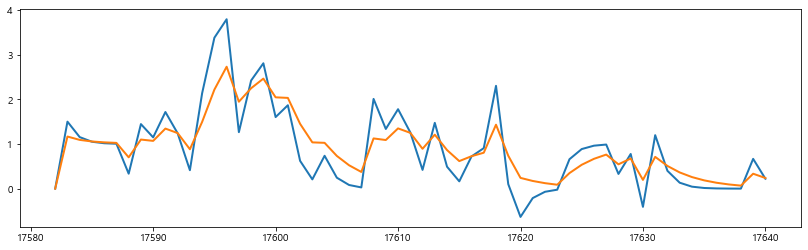

In [196]:
plt.plot(ewm_month_list[14].amount_2ewm)
# plt.plot(ewm_month_list[14].amount_3ewm)
plt.plot(ewm_month_list[14].amount_6ewm)
plt.show()

In [185]:
ewm_month

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,amount_2ewm,amount_3ewm,amount_6ewm,shopkey,ratio,scskey,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
50445,2019-11-18,3,3,0,0,3,0.000000,0.000000,0.000000,X10038,0.000000,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50446,2019-11-25,0,3,0,0,3,0.000000,0.000000,0.000000,X10038,0.000000,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50447,2019-12-02,0,3,0,0,3,0.000000,0.000000,0.000000,X10038,0.000000,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50448,2019-12-09,0,3,1,1,2,0.675000,0.533333,0.386261,X10038,0.022727,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50449,2019-12-16,1,4,0,1,3,0.223140,0.258065,0.250694,X10038,0.022727,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50450,2019-12-23,0,4,3,4,0,2.076923,1.650794,1.156512,X10038,0.090909,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50451,2019-12-30,3,7,1,5,2,1.358646,1.322835,1.107108,X10038,0.113636,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50452,2020-01-06,1,8,0,5,3,0.452744,0.658824,0.767800,X10038,0.113636,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50453,2020-01-13,0,8,0,5,3,0.150899,0.328767,0.537271,X10038,0.113636,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50454,2020-01-20,0,8,1,6,2,0.716976,0.664712,0.674213,X10038,0.136364,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남


In [132]:
# def make_wma_sub(data_frame, span_num):
# make_wma_sub(sma_month_list[0], 2)
# concat_3wek = pd.DataFrame(index=pd.to_datetime(['2021-01-05', '2021-01-12', '2021-01-19']))
concat_3wek = pd.DataFrame(index=pd.to_datetime(['2021-01-05', '2021-01-12', '2021-01-19']))

wma_sub = np.array([])

#     for i in df_month.store_id.unique():
df_set = pd.DataFrame(sma_month_list[0].week_sale_qty)
# 비어있는 셀 만들어주기
wma_train = pd.concat([df_set, concat_3wek], axis=0)
print(wma_train)
print('wwww')
# 세달 예측 후 합하기
num_sub = np.array([wma_train.week_sale_qty.ewm(span=2).mean().values])
print(num_sub)
#     print(len(num_sub))
print('wwww')

wma_sub = np.concatenate((wma_sub, num_sub))
print(wma_sub)
print('wwww')

#     df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})
# return wma_sub

                     week_sale_qty
0                              0.0
1                              0.0
2                              1.0
3                              0.0
4                              0.0
5                              0.0
6                              0.0
7                              0.0
8                              0.0
9                              0.0
10                             1.0
11                             0.0
12                             1.0
13                             0.0
14                             0.0
15                             0.0
16                             0.0
17                             1.0
18                             0.0
19                             0.0
20                             0.0
21                             0.0
22                             0.0
23                             0.0
24                             0.0
25                             0.0
26                             0.0
27                  

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [150]:
test_list = [0]
test_list = test_list + list(ewm_month.amount_2ewm)
test_list

[0,
 0.0,
 0.0,
 0.0,
 0.6749999999999999,
 0.22314049586776863,
 2.0769230769230766,
 1.3586459286367796,
 0.4527439024390245,
 0.15089929885174277,
 0.7169760195095516,
 2.905671028417238,
 0.9685533644437755,
 0.9895178012973541,
 0.9965059352268298,
 0.9988353119046149,
 1.6662784528066248,
 1.8887594859916623,
 1.9629198288553082,
 1.9876399429730383,
 0.6625466472776464,
 1.5541822158444552,
 2.518060738645534,
 0.8393535795306799,
 0.9464511931772724,
 1.6488170643932532,
 -0.11706097853627684,
 -0.03902032617874872,
 0.6536598912737807,
 0.21788663042458725,
 0.7392955434748649,
 0.2464318478249542,
 0.7488106159416515,
 0.9162702053138839,
 0.3054234017712946,
 0.10180780059043154,
 0.7006026001968105,
 -0.4331324666010632,
 0.5222891777996456,
 1.5074297259332152,
 0.5024765753110717,
 0.16749219177035723,
 0.05583073059011908,
 0.018610243530039695,
 0.006203414510013231,
 0.002067804836671077,
 0.667355934945557,
 0.22245197831518568,
 0.07415065943839523,
 1.35805021981279

In [151]:
mae(list(ewm_month.week_sale_qty),test_list[:-1])

0.8392586490545553

In [148]:
mae(ewm_month.week_sale_qty,ewm_month.amount_3ewm)

0.4068761161365578

In [146]:
ewm_month

,weekkey,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,amount_2ewm,amount_3ewm,amount_6ewm,shopkey,ratio,scskey,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
50445,2019-11-18,3,3,0,0,3,0.000000,0.000000,0.000000,X10038,0.000000,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50446,2019-11-25,0,3,0,0,3,0.000000,0.000000,0.000000,X10038,0.000000,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50447,2019-12-02,0,3,0,0,3,0.000000,0.000000,0.000000,X10038,0.000000,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50448,2019-12-09,0,3,1,1,2,0.675000,0.533333,0.386261,X10038,0.022727,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50449,2019-12-16,1,4,0,1,3,0.223140,0.258065,0.250694,X10038,0.022727,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50450,2019-12-23,0,4,3,4,0,2.076923,1.650794,1.156512,X10038,0.090909,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50451,2019-12-30,3,7,1,5,2,1.358646,1.322835,1.107108,X10038,0.113636,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50452,2020-01-06,1,8,0,5,3,0.452744,0.658824,0.767800,X10038,0.113636,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50453,2020-01-13,0,8,0,5,3,0.150899,0.328767,0.537271,X10038,0.113636,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남
50454,2020-01-20,0,8,1,6,2,0.716976,0.664712,0.674213,X10038,0.136364,X20SDXSHA5011OW270,롯데창원,디스커버리 롯데 창원점,XH0237,일반매장,백화점특정,백화점,경남


In [136]:
mae(ewm_month.week_sale_qty,ewm_month.amount_6ewm)

0.5541107758023927

In [122]:
test

array([9.64071715])

In [ ]:
def make_wma_sub(data_frame, span_num):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    wma_sub = np.array([])

    for i in df_month.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        wma_train = pd.concat([df_set, concat_3mon], axis=0)

        num_sub = np.array([wma_train.amount.ewm(span=span_num).mean()['2019-03':].sum()])

        wma_sub = np.concatenate((wma_sub, num_sub))
        
    df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})
    
    return df_wma_sub

In [267]:
total_shop_buket = shop_weeks_buket_df.groupby('weekkey').sum()

In [268]:
total_shop_buket_v2 = shop_weeks_buket_v2_df_dep.groupby('weekkey').sum()

In [270]:
total_shop_buket_v2 = total_shop_buket_v2.reset_index()
total_shop_buket_v2['weekkey'] = pd.to_datetime(total_shop_buket_v2['weekkey'])
total_shop_buket_v2 = total_shop_buket_v2.set_index('weekkey')


In [269]:
total_shop_buket = total_shop_buket.reset_index()
total_shop_buket['weekkey'] = pd.to_datetime(total_shop_buket['weekkey'])
total_shop_buket = total_shop_buket.set_index('weekkey')


In [271]:
v2_sma_month = total_shop_buket_v2.copy()
v2_sma_month.insert(6, 'amount_2ma', make_sma_arr(v2_sma_month,2))
v2_sma_month.insert(7, 'amount_4ma', make_sma_arr(v2_sma_month,4))
v2_sma_month.insert(8, 'amount_6ma', make_sma_arr(v2_sma_month,6))
#         amount_2ma_list.append(mae(sma_month.amount_2ma.fillna(0), sma_month.week_sale_qty.values))
#         amount_3ma_list.append(mae(sma_month.amount_3ma.fillna(0), sma_month.week_sale_qty.values))
#         amount_6ma_list.append(mae(sma_month.amount_6ma.fillna(0), sma_month.week_sale_qty.values))
# sma_month_list.append(sma_month)
v2_ewm_month = total_shop_buket_v2.copy()
v2_ewm_month.insert(6, 'amount_2ewm', make_ewm_arr(v2_ewm_month, 2))
v2_ewm_month.insert(7, 'amount_4ewm', make_ewm_arr(v2_ewm_month, 4))
v2_ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(v2_ewm_month, 6))

In [272]:
bk_sma_month = total_shop_buket.copy()
bk_sma_month.insert(6, 'amount_2ma', make_sma_arr(bk_sma_month,2))
bk_sma_month.insert(7, 'amount_4ma', make_sma_arr(bk_sma_month,4))
bk_sma_month.insert(8, 'amount_6ma', make_sma_arr(bk_sma_month,6))
#         amount_2ma_list.append(mae(sma_month.amount_2ma.fillna(0), sma_month.week_sale_qty.values))
#         amount_3ma_list.append(mae(sma_month.amount_3ma.fillna(0), sma_month.week_sale_qty.values))
#         amount_6ma_list.append(mae(sma_month.amount_6ma.fillna(0), sma_month.week_sale_qty.values))
# sma_month_list.append(sma_month)
bk_ewm_month = total_shop_buket.copy()
bk_ewm_month.insert(6, 'amount_2ewm', make_ewm_arr(bk_ewm_month, 2))
bk_ewm_month.insert(7, 'amount_4ewm', make_ewm_arr(bk_ewm_month, 4))
bk_ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(bk_ewm_month, 6))

In [275]:
v2_sma_month.to_csv('v2_sma_month.csv')
v2_ewm_month.to_csv('v2_ewm_month.csv')

In [273]:
bk_ewm_month.to_csv('bk_ewm_month.csv')
bk_sma_month.to_csv('bk_sma_month.csv')

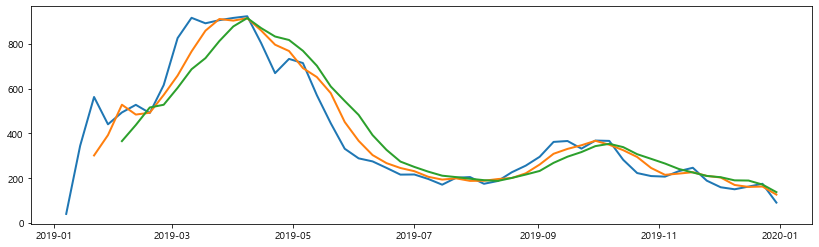

In [276]:
plt.plot(bk_sma_month.amount_2ma)
plt.plot(bk_sma_month.amount_4ma)
plt.plot(bk_sma_month.amount_6ma)
plt.show()

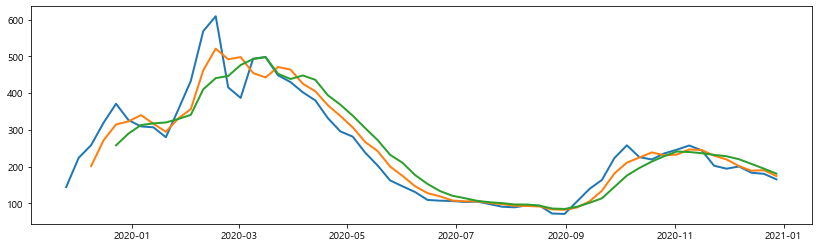

In [277]:
plt.plot(v2_sma_month.amount_2ma)
plt.plot(v2_sma_month.amount_4ma)
plt.plot(v2_sma_month.amount_6ma)
plt.show()

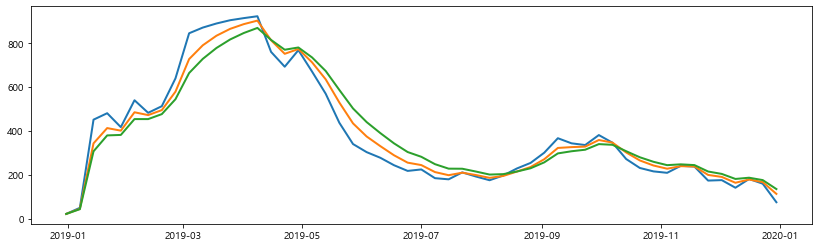

In [278]:
plt.plot(bk_ewm_month.amount_2ewm)
plt.plot(bk_ewm_month.amount_4ewm)
plt.plot(bk_ewm_month.amount_6ewm)
# plt.plot(sma_month.amount_6ma)
plt.show()

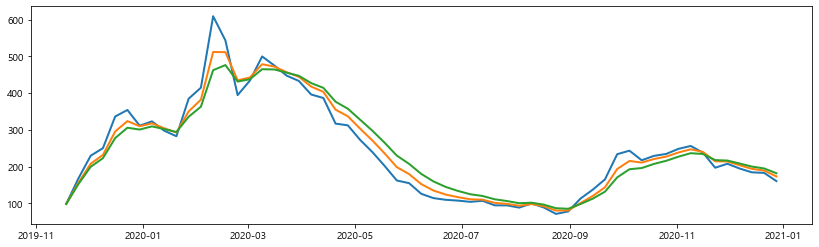

In [279]:
plt.plot(v2_ewm_month.amount_2ewm)
plt.plot(v2_ewm_month.amount_4ewm)
plt.plot(v2_ewm_month.amount_6ewm)
# plt.plot(sma_month.amount_6ma)
plt.show()

In [246]:
shop_weeks_buket_v2_df_dep[(shop_weeks_buket_v2_df_dep['stock_qty']==0) & shop_weeks_buket_v2_df_dep['takeout_qty']>0].groupby('weekkey').count()

,week_takeout_qty,takeout_qty,week_sale_qty,sale_qty,stock_qty,shopkey,ratio,scskey,shop_nm,shop_nm_sfdc,repr_shopcode,type_shop_nm,type_contract_nm,type_zone_nm,region_nm
weekkey,,,,,,,,,,,,,,,
2019-11-18,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
2019-11-25,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
2019-12-02,16,16,16,16,16,16,16,16,16,16,16,16,16,16,16
2019-12-09,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
2019-12-16,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
2019-12-23,9,9,9,9,9,9,9,9,9,9,9,9,9,9,9
2019-12-30,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2020-01-06,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
2020-01-13,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
